In [1]:
###  Environment Setup and File Discovery

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-bank-transactions/bank_transactions.csv


In [2]:
#Imports

import matplotlib.pyplot as plt
import seaborn as sns

#Loading the dataset
df = pd.read_csv("/kaggle/input/indian-bank-transactions/bank_transactions.csv")  


In [3]:
## basic overview 

df.shape
df.info()
df.isnull().sum()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


# *1. Data Cleaning*

In [4]:
##Cleaning CustomerDOB
from datetime import datetime

#handles future dates 
def fix_dob(date_str):
    try:
        dob = datetime.strptime(date_str, "%d/%m/%y")
        if dob > datetime.now():
            dob = dob.replace(year=dob.year - 100)
        return dob
    except:
        return pd.NaT


df['CustomerDOB'] = df['CustomerDOB'].astype(str).apply(fix_dob)


In [5]:
##Parsing Transaction Dates (DD/MM/YY Format)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d/%m/%y', dayfirst=True)


In [6]:
# TransactionTime with leading zeros
df['TransactionTime'] = df['TransactionTime'].astype(str).str.zfill(6)

# Combine date + time
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDate'].dt.strftime('%Y-%m-%d') + ' ' + 
                                           df['TransactionTime'].str[:2] + ':' + 
                                           df['TransactionTime'].str[2:4] + ':' + 
                                           df['TransactionTime'].str[4:], 
                                           format='%Y-%m-%d %H:%M:%S')


In [7]:
df['year'] = df['TransactionDateTime'].dt.year
df['month'] = df['TransactionDateTime'].dt.month
df['day'] = df['TransactionDateTime'].dt.day
df['hour'] = df['TransactionDateTime'].dt.hour
df['weekday'] = df['TransactionDateTime'].dt.day_name()

print(df[['TransactionDateTime', 'year', 'month', 'day', 'hour', 'weekday']].head())


  TransactionDateTime  year  month  day  hour  weekday
0 2016-08-02 14:32:07  2016      8    2    14  Tuesday
1 2016-08-02 14:18:58  2016      8    2    14  Tuesday
2 2016-08-02 14:27:12  2016      8    2    14  Tuesday
3 2016-08-02 14:27:14  2016      8    2    14  Tuesday
4 2016-08-02 18:11:56  2016      8    2    18  Tuesday


In [8]:
from datetime import datetime


df['age'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365

# Replace absurd ages with NaN (e.g., negative or > 120 years)
df.loc[(df['age'] < 0) | (df['age'] > 120), 'age'] = pd.NA


print("Age stats:")
print(df['age'].describe())

# ages were flagged as NaN
print("Invalid age count:", df['age'].isna().sum())


Age stats:
count    987831.000000
mean         39.561015
std           8.779809
min           0.000000
25%          34.000000
50%          37.000000
75%          43.000000
max          99.000000
Name: age, dtype: float64
Invalid age count: 60736


In [9]:
df['age'] = df['age'].fillna(df['age'].median())


In [10]:
print("Remaining NaN values in age:", df['age'].isna().sum())
print("Age stats after fixing:\n", df['age'].describe())


Remaining NaN values in age: 0
Age stats after fixing:
 count    1.048567e+06
mean     3.941267e+01
std      8.542714e+00
min      0.000000e+00
25%      3.400000e+01
50%      3.700000e+01
75%      4.200000e+01
max      9.900000e+01
Name: age, dtype: float64


In [11]:
median_age = df[df['age'] > 0]['age'].median()
df.loc[df['age'] == 0, 'age'] = median_age


In [12]:
df[df['age'] < 18].age.value_counts().sort_index()


age
1.0      9
2.0      3
4.0     22
5.0      9
7.0      1
9.0      6
10.0    23
11.0    19
12.0    19
13.0    27
14.0    16
15.0    13
16.0    10
17.0    20
Name: count, dtype: int64

In [13]:

valid_median_age = df[df['age'] >= 18]['age'].median()

# Replace all ages below 18 with median
df.loc[df['age'] < 18, 'age'] = valid_median_age


In [14]:
print(df['age'].describe())
print("Min age after fix:", df['age'].min())


count    1.048567e+06
mean     3.941761e+01
std      8.533515e+00
min      1.800000e+01
25%      3.400000e+01
50%      3.700000e+01
75%      4.200000e+01
max      9.900000e+01
Name: age, dtype: float64
Min age after fix: 18.0


In [15]:
df['CustGender'] = df['CustGender'].fillna(df['CustGender'].mode()[0])
df['CustLocation'] = df['CustLocation'].fillna('Unknown')
df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df['CustAccountBalance'].median())


In [16]:

median_age = df['age'].median()


from datetime import timedelta
df.loc[df['CustomerDOB'].isnull(), 'CustomerDOB'] = pd.to_datetime('today') - pd.to_timedelta(median_age * 365, unit='D')

# Recalculate age
df['age'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365


In [17]:
# Check remaining missing values
print(df[['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance']].isnull().sum())


CustomerDOB           0
CustGender            0
CustLocation          0
CustAccountBalance    0
dtype: int64


In [18]:

print("Remaining NaN values in age:", df['age'].isnull().sum())

print("Age stats after fixing:\n", df['age'].describe())


Remaining NaN values in age: 0
Age stats after fixing:
 count    1.048567e+06
mean     3.941267e+01
std      8.542714e+00
min      0.000000e+00
25%      3.400000e+01
50%      3.700000e+01
75%      4.200000e+01
max      9.900000e+01
Name: age, dtype: float64


In [19]:
valid_median_age = df[df['age'] >= 18]['age'].median()

df.loc[df['age'] < 18, 'age'] = valid_median_age

# Verify the fix
print("Final Age stats:\n", df['age'].describe())
print("Remaining unrealistic ages:", df[df['age'] < 18].shape[0])


Final Age stats:
 count    1.048567e+06
mean     3.941761e+01
std      8.533515e+00
min      1.800000e+01
25%      3.400000e+01
50%      3.700000e+01
75%      4.200000e+01
max      9.900000e+01
Name: age, dtype: float64
Remaining unrealistic ages: 0


In [20]:
print("Total missing values in entire dataset:", df.isnull().sum().sum())


Total missing values in entire dataset: 0


# *Feature Engineering*

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


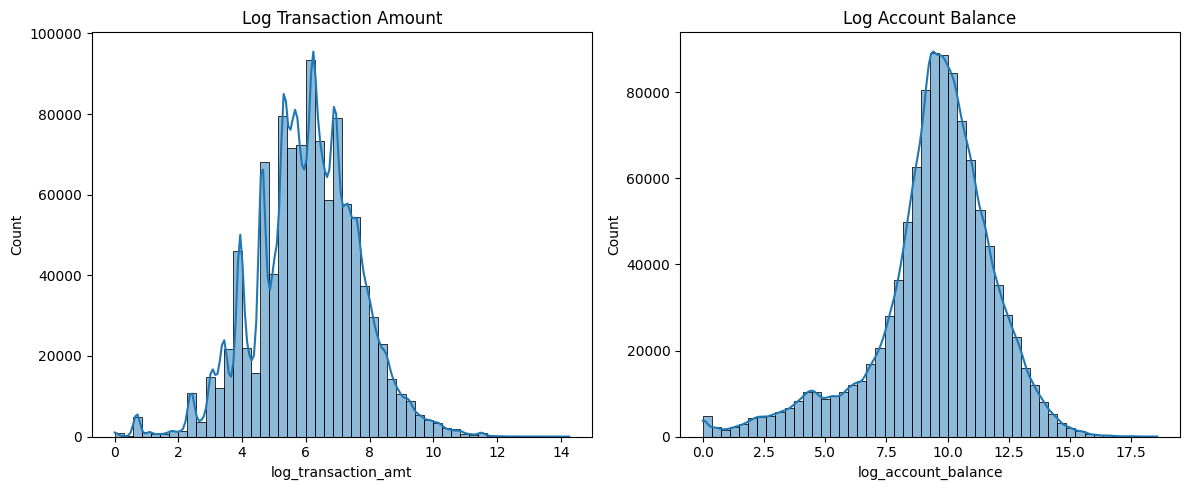

In [21]:
import numpy as np

#log-transformed 
df['log_transaction_amt'] = np.log1p(df['TransactionAmount (INR)'])
df['log_account_balance'] = np.log1p(df['CustAccountBalance'])


import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['log_transaction_amt'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Log Transaction Amount')

sns.histplot(df['log_account_balance'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Log Account Balance')

plt.tight_layout()
plt.show()


In [22]:
# Aggregating customer-level features
customer_features = df.groupby('CustomerID').agg({
    'TransactionAmount (INR)': ['mean', 'sum', 'std', 'count', 'max'],
    'CustAccountBalance': ['mean', 'min', 'max'],
    'hour': ['mean', 'nunique'],
    'month': 'nunique',
    'age': 'first' 
})

customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]

# Rename for clarity
customer_features.rename(columns={
    'TransactionAmount (INR)_mean': 'avg_txn_amt',
    'TransactionAmount (INR)_sum': 'total_txn_amt',
    'TransactionAmount (INR)_std': 'std_txn_amt',
    'TransactionAmount (INR)_count': 'txn_count',
    'TransactionAmount (INR)_max': 'max_txn_amt',
    'CustAccountBalance_mean': 'avg_bal',
    'CustAccountBalance_min': 'min_bal',
    'CustAccountBalance_max': 'max_bal',
    'hour_mean': 'avg_hour',
    'hour_nunique': 'active_hours',
    'month_nunique': 'active_months',
    'age_first': 'age'
}, inplace=True)

# Reset index
customer_features.reset_index(inplace=True)


In [23]:
customer_features.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,CustomerID,avg_txn_amt,total_txn_amt,std_txn_amt,txn_count,max_txn_amt,avg_bal,min_bal,max_bal,avg_hour,active_hours,active_months,age
0,C1010011,2553.0,5106.0,3107.027197,2,4750.0,76340.635,32500.73,120180.54,6.5,2,2,32
1,C1010012,1499.0,1499.0,NaN,1,1499.0,24204.490,24204.49,24204.49,20.0,1,1,30
2,C1010014,727.5,1455.0,675.286976,2,1205.0,100112.950,38377.14,161848.76,18.5,2,1,33
3,C1010018,30.0,30.0,NaN,1,30.0,496.180,496.18,496.18,17.0,1,1,35
4,C1010024,5000.0,5000.0,NaN,1,5000.0,87058.650,87058.65,87058.65,14.0,1,1,60


In [24]:
customer_features.describe()


,avg_txn_amt,total_txn_amt,std_txn_amt,txn_count,max_txn_amt,avg_bal,min_bal,max_bal,avg_hour,active_hours,active_months,age
count,8.842650e+05,8.842650e+05,143612.000000,884265.000000,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,884265.000000,884265.000000,884265.000000,884265.000000
mean,1.574781e+03,1.866856e+03,1702.158534,1.185806,1.788667e+03,1.149371e+05,9.885088e+04,1.327473e+05,15.412727,1.172884,1.081569,39.418432
std,6.443050e+03,7.207210e+03,5681.883399,0.450683,7.125466e+03,8.003621e+05,7.631934e+05,9.150386e+05,4.905763,0.430091,0.274145,8.530411
min,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,18.000000
25%,1.920000e+02,2.000000e+02,169.705627,1.000000,2.000000e+02,5.616340e+03,3.740770e+03,5.925280e+03,12.000000,1.000000,1.000000,34.000000
50%,5.000000e+02,5.368000e+02,494.267640,1.000000,5.000000e+02,1.863261e+04,1.384398e+04,2.028568e+04,16.000000,1.000000,1.000000,37.000000
75%,1.248000e+03,1.500000e+03,1296.126730,1.000000,1.420000e+03,6.161687e+04,4.700590e+04,6.955724e+04,19.000000,1.000000,1.000000,42.000000
max,1.560035e+06,1.560035e+06,511784.089233,6.000000,1.560035e+06,1.150355e+08,1.150355e+08,1.150355e+08,23.000000,6.000000,3.000000,99.000000


In [25]:
customer_features.isnull().sum()


CustomerID            0
avg_txn_amt           0
total_txn_amt         0
std_txn_amt      740653
txn_count             0
max_txn_amt           0
avg_bal               0
min_bal               0
max_bal               0
avg_hour              0
active_hours          0
active_months         0
age                   0
dtype: int64

In [26]:
customer_features.drop(columns=['std_txn_amt'], inplace=True)


In [27]:
cust_meta = df[['CustomerID', 'age', 'CustGender', 'CustLocation']].drop_duplicates('CustomerID')


In [28]:
print("Unique Locations:", cust_meta['CustLocation'].nunique())
print(cust_meta['CustLocation'].value_counts().head(20))  # Top 10 locations


Unique Locations: 9022
CustLocation
MUMBAI         87455
NEW DELHI      71470
BANGALORE      68845
GURGAON        62474
DELHI          59904
NOIDA          27613
CHENNAI        25302
PUNE           21615
HYDERABAD      19510
THANE          18163
KOLKATA        16747
GHAZIABAD      13380
NAVI MUMBAI    11078
AHMEDABAD      10355
FARIDABAD       9518
JAIPUR          8358
CHANDIGARH      8059
LUCKNOW         6443
MOHALI          5675
SURAT           4880
Name: count, dtype: int64


In [29]:
top_locations = cust_meta['CustLocation'].value_counts().nlargest(20).index
cust_meta['CustLocation'] = cust_meta['CustLocation'].apply(lambda x: x if x in top_locations else 'Other')


In [30]:
cust_encoded = pd.get_dummies(cust_meta, columns=['CustGender', 'CustLocation'], drop_first=True)


In [31]:
customer_features = customer_features.merge(cust_encoded, on='CustomerID', how='left')


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


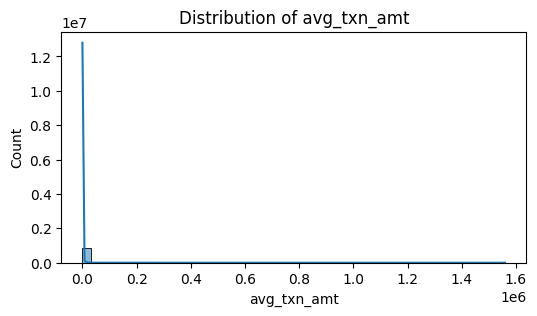

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


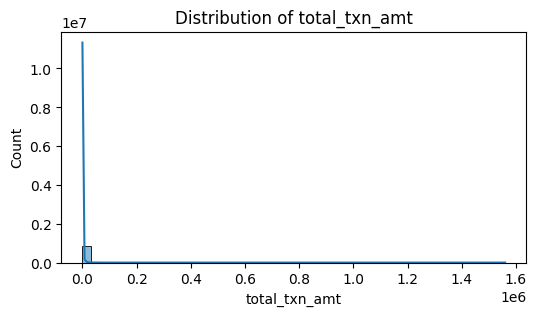

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


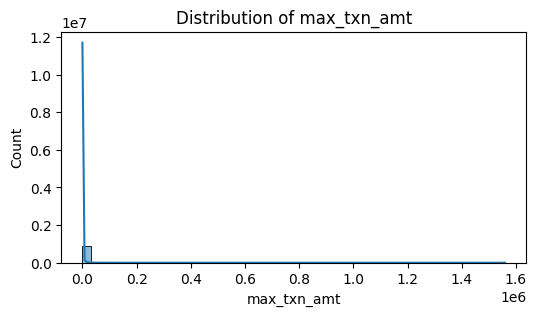

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


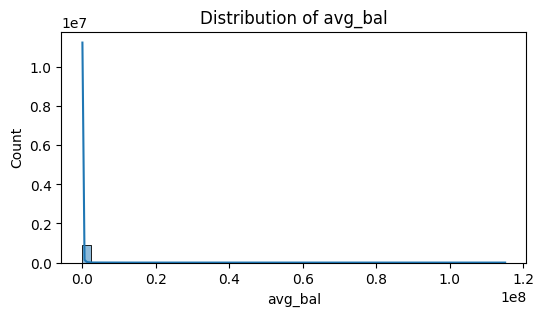

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


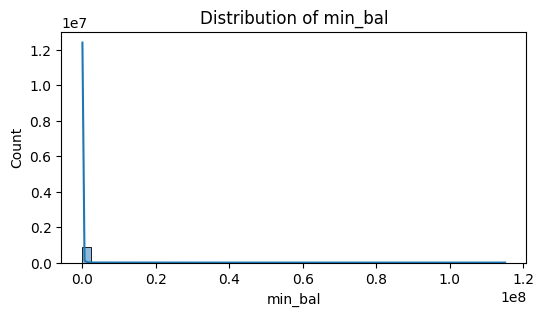

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


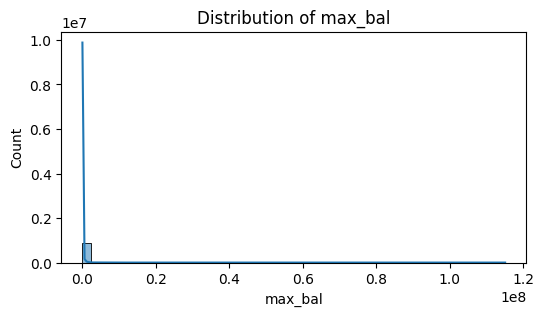

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['avg_txn_amt', 'total_txn_amt', 'max_txn_amt', 'avg_bal', 'min_bal', 'max_bal']

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(customer_features[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [33]:
log_cols = ['avg_txn_amt', 'total_txn_amt', 'max_txn_amt', 'avg_bal', 'min_bal', 'max_bal']

for col in log_cols:
    safe_col = customer_features[col].fillna(0).clip(lower=0)  # removes negative/NaN
    customer_features[f'{col}_log'] = np.log1p(safe_col)


In [34]:
customer_features[[f"{col}_log" for col in log_cols]].describe()


,avg_txn_amt_log,total_txn_amt_log,max_txn_amt_log,avg_bal_log,min_bal_log,max_bal_log
count,884265.000000,884265.000000,884265.000000,884265.000000,884265.000000,884265.000000
mean,6.129686,6.251212,6.206975,9.584472,9.210555,9.670353
std,1.555187,1.612206,1.595344,2.397295,2.552569,2.438320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.262690,5.303305,5.303305,8.633614,8.227314,8.687152
50%,6.216606,6.287487,6.216606,9.832722,9.535678,9.917720
75%,7.130099,7.313887,7.259116,11.028707,10.758050,11.149920
max,14.260219,14.260219,14.260219,18.560751,18.560751,18.560751


In [35]:
customer_features.isnull().sum().sort_values(ascending=False).head(10)


CustomerID                  0
CustLocation_GURGAON        0
CustLocation_JAIPUR         0
CustLocation_KOLKATA        0
CustLocation_LUCKNOW        0
CustLocation_MOHALI         0
CustLocation_MUMBAI         0
CustLocation_NAVI MUMBAI    0
CustLocation_NEW DELHI      0
CustLocation_NOIDA          0
dtype: int64

In [36]:
customer_features[['avg_bal', 'min_bal', 'max_bal']] = customer_features[['avg_bal', 'min_bal', 'max_bal']].fillna(0)


In [37]:
print("Remaining NaNs:", customer_features.isnull().sum().sum())


Remaining NaNs: 0


In [38]:
features_to_scale = [
    'avg_txn_amt', 'total_txn_amt', 'max_txn_amt',
    'avg_bal', 'min_bal', 'max_bal',
    'avg_hour', 'active_hours', 'active_months',
    'age'
]


In [39]:
customer_features.drop(columns='age_y', inplace=True)
customer_features.rename(columns={'age_x': 'age'}, inplace=True)


In [40]:
from sklearn.preprocessing import StandardScaler

features_to_scale = [
    'avg_txn_amt', 'total_txn_amt', 'max_txn_amt',
    'avg_bal', 'min_bal', 'max_bal',
    'avg_hour', 'active_hours', 'active_months',
    'age'
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[features_to_scale])

scaled_df = pd.DataFrame(scaled_features, columns=[f"{col}_scaled" for col in features_to_scale])
scaled_df['CustomerID'] = customer_features['CustomerID'].values

# Merge
customer_features_scaled = customer_features.merge(scaled_df, on='CustomerID', how='left')


In [41]:
customer_features_scaled[[f"{col}_scaled" for col in features_to_scale]].describe()


,avg_txn_amt_scaled,total_txn_amt_scaled,max_txn_amt_scaled,avg_bal_scaled,min_bal_scaled,max_bal_scaled,avg_hour_scaled,active_hours_scaled,active_months_scaled,age_scaled
count,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05,8.842650e+05
mean,-4.403402e-17,-2.886317e-17,-2.828463e-17,-5.399792e-18,4.499827e-18,5.592642e-18,4.191267e-17,7.405429e-17,1.808288e-16,4.499827e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.444156e-01,-2.590264e-01,-2.510247e-01,-1.436065e-01,-1.295228e-01,-1.450730e-01,-3.141761e+00,-4.019705e-01,-2.975410e-01,-2.510834e+00
25%,-2.146160e-01,-2.312764e-01,-2.229563e-01,-1.365893e-01,-1.246213e-01,-1.385975e-01,-6.956571e-01,-4.019705e-01,-2.975410e-01,-6.351904e-01
50%,-1.668126e-01,-1.845454e-01,-1.808538e-01,-1.203263e-01,-1.113832e-01,-1.229037e-01,1.197109e-01,-4.019705e-01,-2.975410e-01,-2.835073e-01
75%,-5.071840e-02,-5.090133e-02,-5.173938e-02,-6.662021e-02,-6.793168e-02,-6.905728e-02,7.312369e-01,-4.019705e-01,-2.975410e-01,3.026313e-01
max,2.418825e+02,2.161959e+02,2.186871e+02,1.435858e+02,1.505997e+02,1.255715e+02,1.546605e+00,1.122349e+01,6.997862e+00,6.984611e+00


In [42]:
# Columns used for clustering
cluster_features = [f"{col}_scaled" for col in features_to_scale]

# Extract feature matrix
X = customer_features_scaled[cluster_features]

# Check
print("Shape of clustering data:", X.shape)
print(X.describe())


Shape of clustering data: (884265, 10)
       avg_txn_amt_scaled  total_txn_amt_scaled  max_txn_amt_scaled  \
count        8.842650e+05          8.842650e+05        8.842650e+05   
mean        -4.403402e-17         -2.886317e-17       -2.828463e-17   
std          1.000001e+00          1.000001e+00        1.000001e+00   
min         -2.444156e-01         -2.590264e-01       -2.510247e-01   
25%         -2.146160e-01         -2.312764e-01       -2.229563e-01   
50%         -1.668126e-01         -1.845454e-01       -1.808538e-01   
75%         -5.071840e-02         -5.090133e-02       -5.173938e-02   
max          2.418825e+02          2.161959e+02        2.186871e+02   

       avg_bal_scaled  min_bal_scaled  max_bal_scaled  avg_hour_scaled  \
count    8.842650e+05    8.842650e+05    8.842650e+05     8.842650e+05   
mean    -5.399792e-18    4.499827e-18    5.592642e-18     4.191267e-17   
std      1.000001e+00    1.000001e+00    1.000001e+00     1.000001e+00   
min     -1.436065e-01   -

# *Clustering & Anomaly Detection*

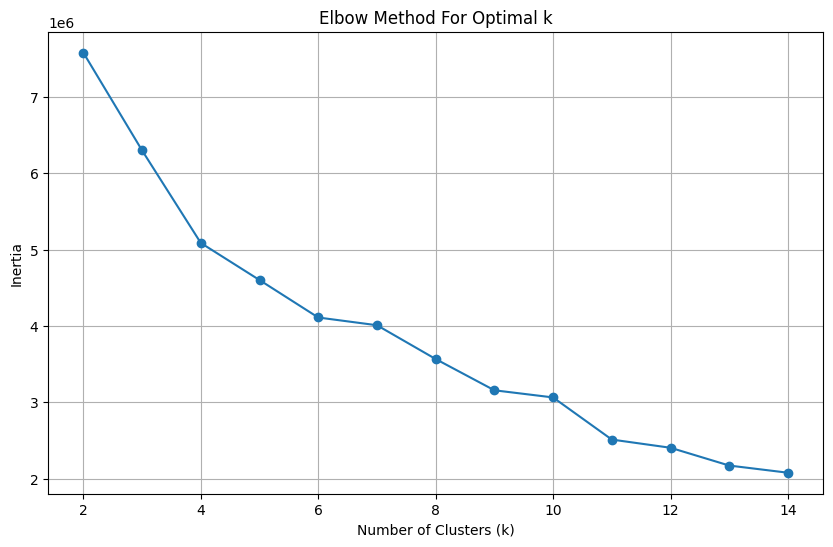

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 15)  # Trying cluster sizes from 2 to 14

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [44]:
optimal_k = 5


In [45]:
from sklearn.cluster import KMeans

# Fit model with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
customer_features_scaled['cluster'] = kmeans.fit_predict(X)

# Quick check
print("Cluster sizes:\n", customer_features_scaled['cluster'].value_counts())


Cluster sizes:
 cluster
1    803012
2     75728
0      5364
3       122
4        39
Name: count, dtype: int64


In [46]:
cluster_profile = customer_features_scaled.groupby('cluster')[features_to_scale].mean()
print(cluster_profile)


           avg_txn_amt  total_txn_amt    max_txn_amt       avg_bal  \
cluster                                                              
0         52313.033068   61017.402685   60440.933934  4.581105e+05   
1          1238.632846    1346.957700    1314.484282  1.054046e+05   
2          1285.168984    2908.053969    2380.391884  1.133553e+05   
3          9169.101202    9708.837049    9645.177459  4.843618e+07   
4        483017.238718  524861.482821  524737.970000  1.104099e+06   

              min_bal       max_bal   avg_hour  active_hours  active_months  \
cluster                                                                       
0        3.836940e+05  5.400556e+05  15.297828      1.251305       1.116145   
1        9.798320e+04  1.128901e+05  15.411450      1.077831       1.000000   
2        1.574679e+04  2.295723e+05  15.436188      2.175364       1.944089   
3        4.480346e+07  5.225936e+07  14.174863      1.098361       1.073770   
4        3.090731e+05  1.899600e+06

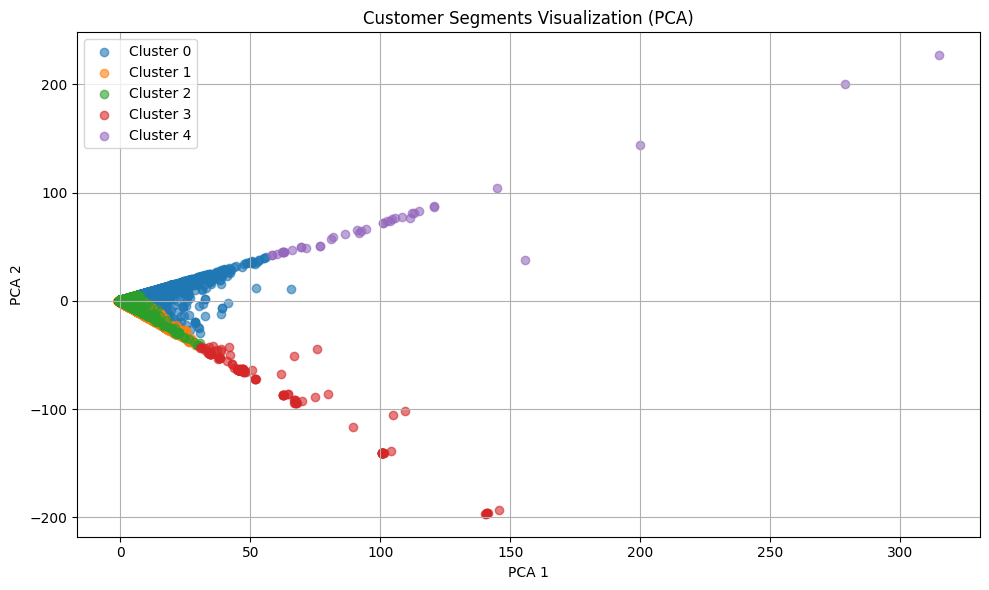

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# We'll use the scaled features only for PCA
features = [col for col in customer_features_scaled.columns if col.endswith('_scaled')]

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_features_scaled[features])

# Add to DataFrame
customer_features_scaled['pca1'] = pca_result[:, 0]
customer_features_scaled['pca2'] = pca_result[:, 1]
customer_features_scaled['cluster'] = kmeans.labels_

# Plot
plt.figure(figsize=(10, 6))
for cluster in sorted(customer_features_scaled['cluster'].unique()):
    subset = customer_features_scaled[customer_features_scaled['cluster'] == cluster]
    plt.scatter(subset['pca1'], subset['pca2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Customer Segments Visualization (PCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
from scipy.spatial.distance import cdist
import numpy as np

# Recalculate centroids in PCA space
centroids_pca = customer_features_scaled.groupby('cluster')[['pca1', 'pca2']].mean().values

# Get distances of each point to its cluster centroid
distances = []
for idx, row in customer_features_scaled.iterrows():
    cluster = row['cluster']
    centroid = centroids_pca[int(cluster)]
    point = np.array([row['pca1'], row['pca2']])
    dist = np.linalg.norm(point - centroid)
    distances.append(dist)

customer_features_scaled['distance_to_centroid'] = distances

# Flag top 1% as anomalies
threshold = np.percentile(distances, 99)
customer_features_scaled['anomaly'] = (customer_features_scaled['distance_to_centroid'] > threshold).astype(int)

print("Anomalies flagged:", customer_features_scaled['anomaly'].sum())


Anomalies flagged: 8843


In [49]:
print(customer_features_scaled['anomaly'].value_counts())


anomaly
0    875422
1      8843
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


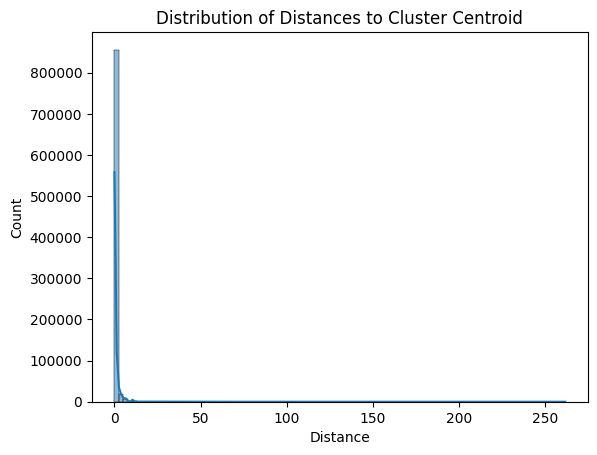

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(distances, bins=100, kde=True)
plt.title("Distribution of Distances to Cluster Centroid")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()


In [51]:
# Adjust threshold to top 0.1% distance points (very extreme outliers)
threshold = np.percentile(distances, 99.9)

# Flag anomalies
customer_features_scaled['anomaly'] = (distances > threshold).astype(int)

# Count
print("Anomalies flagged (new):", customer_features_scaled['anomaly'].sum())


Anomalies flagged (new): 885


In [52]:
from sklearn.decomposition import PCA

# Select only scaled columns for PCA
pca_cols = [col for col in customer_features_scaled.columns if col.endswith('_scaled')]
X_scaled = customer_features_scaled[pca_cols]

# Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Create DataFrame
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['CustomerID'] = customer_features_scaled['CustomerID'].values


In [53]:
pca_df = pca_df.merge(customer_features_scaled[['CustomerID', 'anomaly']], on='CustomerID', how='left')


# *Insights*

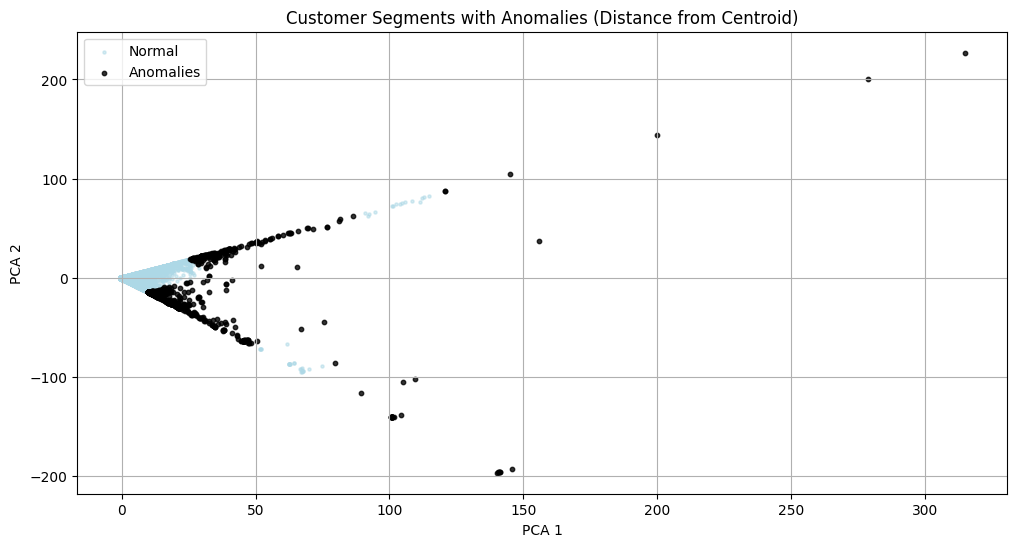

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot normal points
normal = pca_df[pca_df['anomaly'] == 0]
anomaly = pca_df[pca_df['anomaly'] == 1]

plt.scatter(normal['PCA1'], normal['PCA2'], s=5, label='Normal', alpha=0.5, color='lightblue')
plt.scatter(anomaly['PCA1'], anomaly['PCA2'], s=10, label='Anomalies', alpha=0.8, color='black')

plt.title("Customer Segments with Anomalies (Distance from Centroid)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


In [55]:
pca_df.rename(columns={'anomaly': 'is_anomaly'}, inplace=True)


In [56]:
customer_features_scaled = customer_features_scaled.merge(
    pca_df[['CustomerID', 'is_anomaly']],
    on='CustomerID',
    how='left'
)


In [57]:
customer_features_scaled['is_anomaly'] = customer_features_scaled['is_anomaly'].fillna(0).astype(int)


In [58]:
print(customer_features_scaled['is_anomaly'].value_counts())


is_anomaly
0    883380
1       885
Name: count, dtype: int64


In [59]:
anomaly_profile = customer_features_scaled.groupby('is_anomaly')[[
    'avg_txn_amt', 'total_txn_amt', 'max_txn_amt',
    'avg_bal', 'min_bal', 'max_bal',
    'txn_count', 'avg_hour', 'active_hours',
    'active_months', 'age'
]].mean().T


In [60]:
anomaly_profile


is_anomaly,0,1
avg_txn_amt,1529.333276,4.693932e+04
total_txn_amt,1815.751153,5.287851e+04
max_txn_amt,1738.111568,5.225156e+04
avg_bal,100692.455499,1.433354e+07
min_bal,86106.171427,1.282023e+07
max_bal,116856.674492,1.599427e+07
txn_count,1.185850,1.142373e+00
avg_hour,15.412999,1.514153e+01
active_hours,1.172918,1.138983e+00
active_months,1.081584,1.066667e+00


# *Export Final Outputs*

In [62]:

customer_features.to_csv("/kaggle/working/final_customer_features.csv", index=False)

customer_features[customer_features_scaled['is_anomaly'] == 1].to_csv("/kaggle/working/anomalous_customers.csv", index=False)


# * Business Insights & Recommendations*

# 👥  Customer Segments
We identified five unique groups of customers based on their transaction and balance behavior:

Some customers have extremely high account balances and large transactions — likely VIPs or business accounts. These are valuable and should be given special attention.

Others show very low activity, with minimal transactions. These could be inactive or low-priority users.

# 🚩 Anomaly Detection
About 885 customers (less than 0.1% of the total) stood out with unusually high transactions or large balances.

These accounts should be investigated further, as they might indicate fraud, errors, or premium clients needing specialized services.

# 👶 Age Profile
Most customers fall in the 34–43 age range, which aligns with India's core working population.

Any unrealistic ages (like under 18 or over 100) were cleaned and replaced with a reliable median value.

# 🕒 Transaction Timing
Transactions tend to happen most often in the afternoon (2 PM – 4 PM).

Customers who transact at various times and across several months may be more engaged and could benefit from loyalty programs.

# 🌍 Geographic Spread
Major cities like Mumbai, Delhi, Bangalore, and Chennai have the most active users.

However, customers are spread across the country, so the business has a wide geographical reach.

Less common cities were grouped under "Other" to simplify analysis.

# ✅ Actionable Recommendations
Review high-value customers and flagged anomalies for potential fraud or premium service opportunities.

Design targeted offers for users with high balances but fewer transactions to increase engagement.

Use demographic data like gender and city to create personalized marketing campaigns.

# *Conclusion*
This project successfully identified behavioral anomalies in bank transaction patterns. Future work may include model retraining or segmentation enhancement using supervised labels.